In this notebook we will demonstrate different text classification models trained using the IMDB reviews dataset. 

In [1]:
# To install only the requirements of this notebook, uncomment the lines below and run this cell

# ===========================
"""
!pip install numpy==1.19.5
!pip install wget==3.2
!pip install tensorflow==1.14.0
"""

#!pip install numpy wget tensorflow tensorflow_datasets

# ===========================

#started off from: https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
#and from: https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

'\n!pip install numpy==1.19.5\n!pip install wget==3.2\n!pip install tensorflow==1.14.0\n'

In [2]:
#Make the necessary imports
import os
import sys
import numpy as np
import tarfile
import wget
import warnings
warnings.filterwarnings("ignore") 
from zipfile import ZipFile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

Here we set all the paths of all the external datasets and models such as [glove](https://nlp.stanford.edu/projects/glove/) and [IMDB reviews dataset](http://ai.stanford.edu/~amaas/data/sentiment/).

In [3]:
from tensorflow.keras.datasets import imdb

MAX_WORDS = 10000

# Load the IMDb dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=MAX_WORDS)

# The data comes preprocessed as sequences of word indices.
print(train_data[0])  # This will print an integer-encoded review


BASE_DIR = '../../layer-cake/.vector_cache/'

DATA_DIR = '../datasets/IMDB/'

GLOVE_DIR = os.path.join(BASE_DIR, 'GloVe')

TRAIN_DATA_DIR = DATA_DIR + '/train'
TEST_DATA_DIR = DATA_DIR + '/test'

print("GLOVE_DIR: ", GLOVE_DIR)
print("TRAIN_DATA_DIR: ", TRAIN_DATA_DIR)
print("TEST_DATA_DIR: ", TEST_DATA_DIR)

#Within these, I only have a pos/ and a neg/ folder containing text files 
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
GLOVE_DIR:  ../../layer-cake/.vector_cache/GloVe
TRAIN_DATA_

### Loading and Preprocessing
 

In [4]:
#Function to load the data from the dataset into the notebook. Will be called twice - for train and test.
"""
def get_data(data_dir):
    texts = []  # list of text samples
    labels_index = {'pos':1, 'neg':0}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    for name in sorted(os.listdir(data_dir)):
        path = os.path.join(data_dir, name)
        if os.path.isdir(path):
            if name=='pos' or name=='neg':
                label_id = labels_index[name]
                for fname in sorted(os.listdir(path)):
                        fpath = os.path.join(path, fname)
                        text = open(fpath,encoding='utf8').read()
                        texts.append(text)
                        labels.append(label_id)
    return texts, labels

train_texts, train_labels = get_data(TRAIN_DATA_DIR)
test_texts, test_labels = get_data(TEST_DATA_DIR)
"""

train_texts, train_labels = train_data, train_labels
test_texts, test_labels = test_data, test_labels

labels_index = {'pos':1, 'neg':0} 

#Just to see how the data looks like. 
print("train_texts[0]:", train_texts[0])
print("train_labels[0]", train_labels[0])

print("test_texts[24999]:", test_texts[24999])
print("test_labels[24999]:", test_labels[24999])

train_texts[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
train_labels[0] 1
test_texts[24999]: [1, 6, 

In [5]:
#
# prep IMDB data
# 

import tensorflow_datasets as tfds

# Load the IMDb dataset
imdb_data = tfds.load("imdb_reviews", as_supervised=True)

# Split the data into train and test sets
train_data, test_data = imdb_data['train'], imdb_data['test']

# Extract the reviews and labels from the dataset (decode from bytes)
train_texts = [text.decode('utf-8') for text, label in tfds.as_numpy(train_data)]
test_texts = [text.decode('utf-8') for text, label in tfds.as_numpy(test_data)]

# Extract the labels
train_labels = [label for text, label in tfds.as_numpy(train_data)]
test_labels = [label for text, label in tfds.as_numpy(test_data)]

num_classes = 2
print("num_classes:", num_classes)

# Get the class names from the 20 Newsgroups dataset
class_names = ['neg', 'pos']

y_train = train_labels
y_test = test_labels

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

2024-10-19 06:49:05.005194: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


num_classes: 2


In [6]:
"""
from sklearn.datasets import fetch_20newsgroups

MAX_WORDS=20000
MAX_FEATURES=MAX_WORDS

TRAIN_TEST_SPLIT = 0.2
VALIDATION_SPLIT = 0.2

train_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

train_texts = train_texts
test_texts = test_texts

train_labels = train_data.target
test_labels = test_data.target

num_classes = 20
print("num_classes:", num_classes)

# Get the class names from the 20 Newsgroups dataset
class_names = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes')).target_names

y_train = train_data.target
y_test = test_data.target

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

classification_type = 'singlelabel'
"""

'\nfrom sklearn.datasets import fetch_20newsgroups\n\nMAX_WORDS=20000\nMAX_FEATURES=MAX_WORDS\n\nTRAIN_TEST_SPLIT = 0.2\nVALIDATION_SPLIT = 0.2\n\ntrain_data = fetch_20newsgroups(subset=\'train\', remove=(\'headers\', \'footers\', \'quotes\'))\ntest_data = fetch_20newsgroups(subset=\'test\', remove=(\'headers\', \'footers\', \'quotes\'))\n\ntrain_texts = train_texts\ntest_texts = test_texts\n\ntrain_labels = train_data.target\ntest_labels = test_data.target\n\nnum_classes = 20\nprint("num_classes:", num_classes)\n\n# Get the class names from the 20 Newsgroups dataset\nclass_names = fetch_20newsgroups(subset=\'train\', remove=(\'headers\', \'footers\', \'quotes\')).target_names\n\ny_train = train_data.target\ny_test = test_data.target\n\ny_train = to_categorical(y_train, num_classes)\ny_test = to_categorical(y_test, num_classes)\n\nclassification_type = \'singlelabel\'\n'

In [7]:
# Now, train_texts and test_texts can be fed into a tokenizer.
print("train_texts:", type(train_texts), len(train_texts))
print("train_texts[0]:", type(train_texts[0]), train_texts[0])

print("test_texts:", type(test_texts), len(test_texts))
print("test_texts[0]:", type(test_texts[0]), test_texts[0])

print("train_labels:", type(train_labels), len(train_labels))
print("train_labels[0]:", type(train_labels[0]), train_labels[0])

print("test_labels:", type(test_labels), len(test_labels))
print("test_labels[0]:", type(test_labels[0]), test_labels[0])

print("y_train:", type(y_train), y_train.shape)
print("y_train[0]:", type(y_train[0]), y_train[0].shape)
print("y_train[0]:", y_train[0])

print("y_test:", type(y_test), y_test.shape)
print("y_test[0]:", type(y_test[0]), y_test[0].shape)
print("y_test[0]:", y_test[0])

train_texts: <class 'list'> 25000
train_texts[0]: <class 'str'> This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
test_texts: <class 'list'> 25000
test_texts[0]: <class 'str'> There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list 

In [8]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer 
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data. 
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) 
tokenizer.fit_on_texts(train_texts) 
train_sequences = tokenizer.texts_to_sequences(train_texts) #Converting text to a vector of word indexes 
test_sequences = tokenizer.texts_to_sequences(test_texts) 
word_index = tokenizer.word_index 
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [9]:
print("train_sequences:", type(train_sequences), len(train_sequences))              #This is a list of lists, one list for each review
print("train_sequences[0]:", type(train_sequences[0]), len(train_sequences[0]))     #This is a list of word indexes for the first review
print("train_sequences[0]:", train_sequences[0])                                    #This will print a list of word indexes (depends on the tokenizer)

print("test_sequences:", type(test_sequences), len(test_sequences))                       #This is a list of lists, one list for each review
print("test_sequences[0]:", type(test_sequences[0]), len(test_sequences[0]))              #This is a list of word indexes for the 25000th review
print("test_sequences[0]:", test_sequences[0])                                            #This will print a list of word indexes (depends on the tokenizer)

train_sequences: <class 'list'> 25000
train_sequences[0]: <class 'list'> 115
train_sequences[0]: [11, 13, 32, 424, 391, 17, 89, 27, 10553, 8, 31, 1365, 3584, 39, 485, 11037, 196, 23, 84, 153, 18, 11, 212, 328, 27, 65, 246, 214, 8, 476, 57, 65, 84, 113, 97, 21, 5674, 11, 1321, 642, 766, 11, 17, 6, 32, 399, 8169, 175, 2454, 415, 1, 88, 1230, 136, 68, 145, 51, 1, 7576, 68, 228, 65, 2932, 15, 19499, 2903, 18510, 1478, 4939, 2, 38, 3899, 116, 1583, 16, 3584, 13, 161, 18, 3, 1230, 916, 7916, 8, 3, 17, 12, 13, 4138, 4, 98, 144, 1213, 10, 241, 682, 12, 47, 23, 99, 37, 11, 7180, 5514, 37, 1365, 13886, 49, 400, 10, 97, 1196, 866, 140, 9]
test_sequences: <class 'list'> 25000
test_sequences[0]: <class 'list'> 165
test_sequences[0]: [47, 23, 105, 12, 94, 4065, 15, 739, 5064, 9, 13, 311, 4, 1, 578, 348, 15, 1846, 1256, 11077, 15, 667, 7665, 5530, 760, 5, 12, 1025, 424, 477, 18562, 3, 14790, 326, 3559, 19, 228, 2, 14, 5741, 2, 14, 1619, 14, 98, 4, 1, 3549, 99, 10, 771, 1497, 11, 251, 234, 10, 216, 1,

In [10]:
#Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
trainvalid_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.asarray(test_labels))

print("trainvalid_data:", type(trainvalid_data), trainvalid_data.shape)                         #Will print a 2D tensor
print("trainvalid_data[0]:", type(trainvalid_data[0]), trainvalid_data[0].shape)                #Will print a 1D tensor
print("trainvalid_data[0]:", trainvalid_data[0])                                                #Will print a 1D tensor with values as indexes

print("test_data:", type(test_data), test_data.shape)                               #Will print a 2D tensor
print("test_data[0]:", type(test_data[0]), test_data[0].shape)                      #Will print a 1D tensor
print("test_data[0]:\n", test_data[0])                                                #Will print a 1D tensor with values as indexes

trainvalid_data: <class 'numpy.ndarray'> (25000, 1000)
trainvalid_data[0]: <class 'numpy.ndarray'> (1000,)
trainvalid_data[0]: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0    

In [11]:
# split the training data into a training set and a validation set
indices = np.arange(trainvalid_data.shape[0])
print("indices:", type(indices), indices.shape)
print("indices[0]:", type(indices[0]), indices[0].shape)
print("indices[0]:", indices[0])

np.random.shuffle(indices)

indices: <class 'numpy.ndarray'> (25000,)
indices[0]: <class 'numpy.int64'> ()
indices[0]: 0


In [12]:
trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]

num_validation_samples = int(VALIDATION_SPLIT * trainvalid_data.shape[0])
print("num_validation_samples:", num_validation_samples)

num_validation_samples: 5000


In [13]:
x_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]
x_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]

#This is the data we will use for CNN and RNN training

print("x_train:", type(x_train), x_train.shape)
print("y_train:", type(y_train), y_train.shape)
print("x_val:", type(x_val), x_val.shape)
print("y_val:", type(y_val), y_val.shape)

x_train: <class 'numpy.ndarray'> (20000, 1000)
y_train: <class 'numpy.ndarray'> (20000, 2)
x_val: <class 'numpy.ndarray'> (5000, 1000)
y_val: <class 'numpy.ndarray'> (5000, 2)


In [14]:
print('Preparing embedding matrix.')

GLOVE_MODEL = 'glove.6B.100d.txt'
print("GLOVE_MODEL: ", GLOVE_MODEL)

# first, build index mapping words in the embeddings set
# to their embedding vector
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, GLOVE_MODEL),encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))
#print(embeddings_index["google"])

# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
print("Preparing of embedding matrix is done")

print("embedding_layer:", type(embedding_layer))
print("embedding_layer config:\n", embedding_layer.get_config())

Preparing embedding matrix.
GLOVE_MODEL:  glove.6B.100d.txt
Found 400000 word vectors in Glove embeddings.
Preparing of embedding matrix is done
embedding_layer: <class 'keras.layers.core.embedding.Embedding'>
embedding_layer config:
 {'name': 'embedding', 'trainable': False, 'dtype': 'float32', 'batch_input_shape': (None, 1000), 'input_dim': 20001, 'output_dim': 100, 'embeddings_initializer': {'class_name': 'Constant', 'config': {'value': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.40121001, -0.6886    , -0.17046   , ..., -0.63893002,
        -0.90948999, -0.69011003],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.077072  , -0.1725    ,  0.20935  

### 1D CNN Model with pre-trained embedding

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

# Function to detect and set the best available device
def set_device():
    if tf.config.list_physical_devices('GPU'):
        print("Using GPU (CUDA)")
        return "/device:GPU:0"
    elif tf.config.list_physical_devices('MPS'):
        print("Using Apple MPS (Metal Performance Shaders)")
        return "/device:GPU:0"  # MPS is identified as a GPU device in TensorFlow
    else:
        print("Using CPU")
        return "/device:CPU:0"
    
# Set the device
device_name = set_device()
print("Running on device:", device_name)


# Custom F1 Score Callback
class F1ScoreCallback(Callback):

    def __init__(self, validation_data, threshold=0.5):
        super().__init__()
        self.validation_data = validation_data
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        
        """
        print("val_data:", type(val_data), val_data.shape)
        print("val_data[0]:", val_data[0])
        print("val_labels:", type(val_labels), val_labels.shape)
        print("val_labels[0]:", val_labels[0])
        """

        val_predictions = self.model.predict(val_data)
        #print("val_predictions:", type(val_predictions), val_predictions.shape)
        #print("val_predictions[0]:", val_predictions[0])

        # Thresholding for multi-label classification
        val_pred_classes = (val_predictions > self.threshold).astype(int)
        #print("val_pred_classes:", type(val_pred_classes), val_pred_classes.shape)
        #print("val_pred_classes[0]:", val_pred_classes[0])

        # Calculate macro and micro F1 scores
        macro_f1 = f1_score(val_labels, val_pred_classes, average='macro')
        micro_f1 = f1_score(val_labels, val_pred_classes, average='micro')
        
        # Log F1 scores
        print(f"Epoch {epoch + 1}: Macro F1 Score = {macro_f1:.4f}, Micro F1 Score = {micro_f1:.4f}")

Using GPU (CUDA)
Running on device: /device:GPU:0


In [16]:
EPOCHS = 50
BATCH_SIZE = 128

from sklearn.utils.class_weight import compute_class_weight

# Callbacks for learning rate refinement, early stopping, and F1 score tracking
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

f1_callback = F1ScoreCallback(validation_data=(test_data, test_labels))                     # Custom F1 score callback

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("class_weights_dict:\n", class_weights_dict)

class_weights_dict:
 {0: 1.0, 1: 1.0}


In [17]:
print("labels_index:", labels_index)
print("class_names:", class_names)
print("num_classes:", num_classes)

labels_index: {'pos': 1, 'neg': 0}
class_names: ['neg', 'pos']
num_classes: 2


In [18]:
print('Define a 1D CNN model.')

from sklearn.metrics import f1_score, classification_report

with tf.device(device_name):

    cnnmodel = Sequential()
    cnnmodel.add(embedding_layer)
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(MaxPooling1D(5))
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(MaxPooling1D(5))
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(GlobalMaxPooling1D())
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(num_classes, activation='softmax'))

    cnnmodel.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['acc'])
    
    """
    #Train the model. Tune to validation set. 
    cnnmodel.fit(x_train, y_train,
            batch_size=128,
            epochs=10, validation_data=(x_val, y_val))
    """

    # Then pass class_weights_dict to the fit function
    history = cnnmodel.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        callbacks=[reduce_lr, early_stop, f1_callback],
        class_weight=class_weights_dict
        )

Define a 1D CNN model.
Epoch 1/50
782/782 [==============================] - 2s 2ms/step
Epoch 1: Macro F1 Score = 0.6790, Micro F1 Score = 0.6946
157/157 [==============================] - 6s 34ms/step - loss: 0.6950 - acc: 0.5956 - val_loss: 0.5659 - val_acc: 0.6976 - lr: 0.0010
Epoch 2/50
782/782 [==============================] - 2s 2ms/step
Epoch 2: Macro F1 Score = 0.6928, Micro F1 Score = 0.7125
157/157 [==============================] - 5s 30ms/step - loss: 0.5220 - acc: 0.7525 - val_loss: 0.6093 - val_acc: 0.7040 - lr: 0.0010
Epoch 3/50
782/782 [==============================] - 2s 2ms/step
Epoch 3: Macro F1 Score = 0.8346, Micro F1 Score = 0.8346
157/157 [==============================] - 5s 29ms/step - loss: 0.4407 - acc: 0.8008 - val_loss: 0.3754 - val_acc: 0.8374 - lr: 0.0010
Epoch 4/50
782/782 [==============================] - 2s 2ms/step
Epoch 4: Macro F1 Score = 0.7309, Micro F1 Score = 0.7444
157/157 [==============================] - 5s 30ms/step - loss: 0.4056 - acc

In [19]:
print("history:", type(history), history.history.keys())

history: <class 'keras.callbacks.History'> dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


In [20]:
import matplotlib.pyplot as plt

def plot_history(history):

    print(f'plotting history: {history}')

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.clf()

    acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

plotting history: <keras.callbacks.History object at 0x386bcca90>


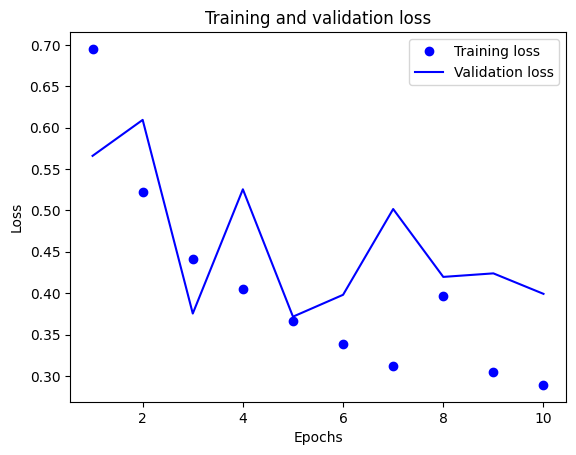

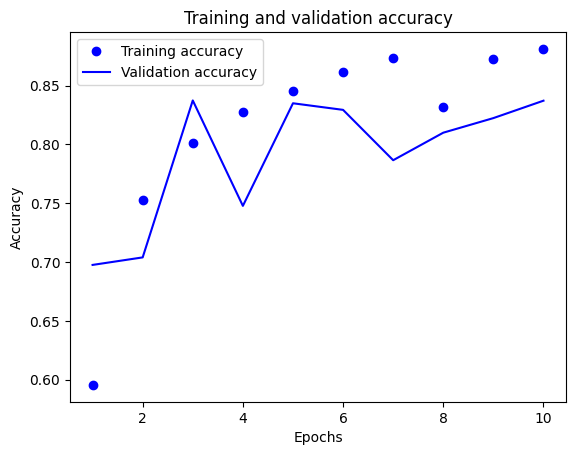

In [21]:
plot_history(history)

In [22]:
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_data, test_labels)
print("score:", score)
print('Test accuracy with CNN:', acc)

782/782 [==============================] - 6s 8ms/step - loss: 0.3893 - acc: 0.8362
score: 0.389316201210022
Test accuracy with CNN: 0.8361999988555908


In [23]:
test_preds = cnnmodel.predict(test_data)
        
# Thresholding for multi-label classification
test_pred_classes = (test_preds > .5).astype(int)

# Classification report with class labels and four decimal places
report = classification_report(test_labels, test_pred_classes, target_names=class_names, digits=4)
print("\nClassification Report:\n", report)

# Calculate macro and micro F1 scores
macro_f1 = f1_score(y_test, test_pred_classes, average='macro')
micro_f1 = f1_score(y_test, test_pred_classes, average='micro')

# Log F1 scores
print(f"\n\tMacro F1 Score = {macro_f1:.4f}, Micro F1 Score = {micro_f1:.4f}")


782/782 [==============================] - 2s 2ms/step

Classification Report:
               precision    recall  f1-score   support

         neg     0.8678    0.7932    0.8288     12500
         pos     0.8096    0.8792    0.8430     12500

   micro avg     0.8362    0.8362    0.8362     25000
   macro avg     0.8387    0.8362    0.8359     25000
weighted avg     0.8387    0.8362    0.8359     25000
 samples avg     0.8362    0.8362    0.8362     25000


	Macro F1 Score = 0.8359, Micro F1 Score = 0.8362


### 1D CNN model with training your own embedding

In [24]:
print("y_train:", type(y_train), y_train.shape)
print("y_train[0]:", y_train[0])

print("x_train:", type(x_train), x_train.shape)
print("x_train[0]:\n", x_train[0])

y_train: <class 'numpy.ndarray'> (20000, 2)
y_train[0]: [0. 1.]
x_train: <class 'numpy.ndarray'> (20000, 1000)
x_train[0]:
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0


In [25]:
print(f"Using device: {device_name}")

print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")

# Define the CNN model
cnnmodel = Sequential()

# Force the Embedding layer to run on the CPU
with tf.device('/CPU:0'):
    cnnmodel.add(Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH))

# Rest of the model can run on the GPU
with tf.device(device_name):
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(MaxPooling1D(5))
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(MaxPooling1D(5))
    cnnmodel.add(Conv1D(128, 5, activation='relu'))
    cnnmodel.add(GlobalMaxPooling1D())
    cnnmodel.add(Dense(128, activation='relu'))
    cnnmodel.add(Dense(num_classes, activation='softmax'))

    cnnmodel.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['acc'])

    #Train the model. Tune to validation set. 
    history2 = cnnmodel.fit(
        x_train, 
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS, 
        validation_data=(x_val, y_val),
        callbacks=[reduce_lr, early_stop, f1_callback],
        class_weight=class_weights_dict
        )

Using device: /device:GPU:0
Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings
Epoch 1/50
782/782 [==============================] - 3s 4ms/step
Epoch 1: Macro F1 Score = 0.8053, Micro F1 Score = 0.8098
157/157 [==============================] - 10s 60ms/step - loss: 0.5132 - acc: 0.7041 - val_loss: 0.3842 - val_acc: 0.8268 - lr: 0.0010
Epoch 2/50
782/782 [==============================] - 3s 4ms/step
Epoch 2: Macro F1 Score = 0.8687, Micro F1 Score = 0.8693
157/157 [==============================] - 9s 58ms/step - loss: 0.2572 - acc: 0.8963 - val_loss: 0.3013 - val_acc: 0.8748 - lr: 0.0010
Epoch 3/50
782/782 [==============================] - 3s 4ms/step
Epoch 3: Macro F1 Score = 0.8757, Micro F1 Score = 0.8757
157/157 [==============================] - 9s 59ms/step - loss: 0.1752 - acc: 0.9327 - val_loss: 0.2670 - val_acc: 0.8944 - lr: 0.0010
Epoch 4/50
782/782 [==============================] - 3s 4ms/step
Epoch 4: Macro F1

history2: <class 'keras.callbacks.History'> dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])
plotting history: <keras.callbacks.History object at 0x366272c50>


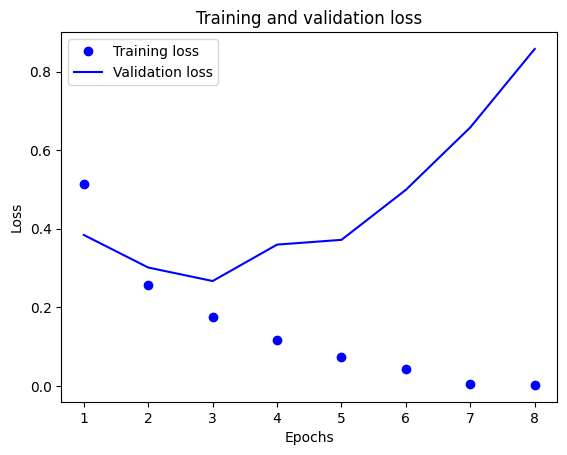

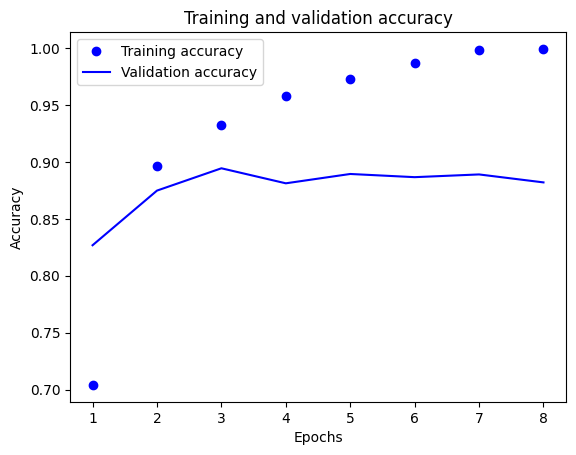

In [26]:
print("history2:", type(history2), history2.history.keys())
plot_history(history2)

In [27]:
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_data, test_labels)
print("score:", score)
print('Test accuracy with CNN:', acc)

782/782 [==============================] - 8s 10ms/step - loss: 0.9905 - acc: 0.8606
score: 0.9905350804328918
Test accuracy with CNN: 0.8605599999427795


In [28]:
test_preds = cnnmodel.predict(test_data)
        
# Thresholding for multi-label classification
test_pred_classes = (test_preds > .5).astype(int)

# Classification report with class labels and four decimal places
report = classification_report(test_labels, test_pred_classes, target_names=class_names, digits=4)
print("\nClassification Report:\n", report)

# Calculate macro and micro F1 scores
macro_f1 = f1_score(y_test, test_pred_classes, average='macro')
micro_f1 = f1_score(y_test, test_pred_classes, average='micro')

# Log F1 scores
print(f"\n\tMacro F1 Score = {macro_f1:.4f}, Micro F1 Score = {micro_f1:.4f}")


782/782 [==============================] - 3s 4ms/step

Classification Report:
               precision    recall  f1-score   support

         neg     0.8803    0.8346    0.8568     12500
         pos     0.8428    0.8865    0.8641     12500

   micro avg     0.8606    0.8606    0.8606     25000
   macro avg     0.8615    0.8606    0.8605     25000
weighted avg     0.8615    0.8606    0.8605     25000
 samples avg     0.8606    0.8606    0.8606     25000


	Macro F1 Score = 0.8605, Micro F1 Score = 0.8606


### LSTM Model with training your own embedding 

In [29]:
print("Defining and training an LSTM model, training embedding layer on the fly")

LSTM_BATCH_SIZE = 32

# Define the RNN model
rnnmodel = Sequential()

# Force the Embedding layer to run on the CPU
with tf.device('/CPU:0'):
        rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))

with tf.device(device_name):
        #rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
        rnnmodel.add(LSTM(128, dropout=0.2))
        rnnmodel.add(Dense(num_classes, activation='sigmoid'))

rnnmodel.compile(loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])

print('Training the RNN')

rnnmodel.fit(
  x_train, 
  y_train,
  batch_size=LSTM_BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(x_val, y_val),
  callbacks=[reduce_lr, early_stop, f1_callback],
  class_weight=class_weights_dict
)

Defining and training an LSTM model, training embedding layer on the fly
Training the RNN
Epoch 1/50
782/782 [==============================] - 14s 18ms/step
Epoch 1: Macro F1 Score = 0.8098, Micro F1 Score = 0.8123
625/625 [==============================] - 56s 87ms/step - loss: 0.4496 - accuracy: 0.7929 - val_loss: 0.4271 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 2/50
782/782 [==============================] - 14s 18ms/step
Epoch 2: Macro F1 Score = 0.8590, Micro F1 Score = 0.8590
625/625 [==============================] - 54s 86ms/step - loss: 0.2832 - accuracy: 0.8895 - val_loss: 0.3586 - val_accuracy: 0.8686 - lr: 0.0010
Epoch 3/50
782/782 [==============================] - 14s 18ms/step
Epoch 3: Macro F1 Score = 0.8578, Micro F1 Score = 0.8578
625/625 [==============================] - 56s 89ms/step - loss: 0.1673 - accuracy: 0.9391 - val_loss: 0.3635 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 4/50
782/782 [==============================] - 15s 19ms/step
Epoch 4: Macro F1 Score = 

In [ ]:
"""
score, acc = rnnmodel.evaluate(
  test_data, 
  test_labels,
  batch_size=32
  )

print('Test accuracy with RNN:', acc)
"""

#Evaluate on test set:
score, acc = rnnmodel.evaluate(test_data, test_labels)
print("score:", score)
print('Test accuracy with CNN:', acc)

### LSTM Model using pre-trained Embedding Layer

In [ ]:
print("Defining and training an LSTM model, using pre-trained embedding layer")

rnnmodel2 = Sequential()
rnnmodel2.add(embedding_layer)
rnnmodel2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel2.add(Dense(2, activation='sigmoid'))

rnnmodel2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Training the RNN')

rnnmodel2.fit(x_train, y_train,
          batch_size=32,
          epochs=1,
          validation_data=(x_val, y_val))
score, acc = rnnmodel2.evaluate(test_data, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)